# Load packages

In [ ]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


import gc
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn import svm
import lightgbm as lgb
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression

pd.set_option('display.max_columns', 100)


RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

#CROSS-VALIDATION
NUMBER_KFOLDS = 5 #number of KFolds for cross-validation



RANDOM_STATE = 2018

MAX_ROUNDS = 1000 #lgb iterations
EARLY_STOP = 50 #lgb early stop
OPT_ROUNDS = 1000  #To be adjusted based on best validation rounds
VERBOSE_EVAL = 50 #Print out metric result

IS_LOCAL = False

import os



# Read the data

In [ ]:
data_df = pd.read_csv("creditcard.csv")

# Check the data

In [ ]:
print("Credit Card Fraud Detection data -  rows:",data_df.shape[0]," columns:", data_df.shape[1])

Credit Card Fraud Detection data -  rows: 26232  columns: 31


In [ ]:
data_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


In [ ]:
data_df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26232.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000,26231.000000
mean,19593.945639,-0.224527,0.164310,0.723193,0.227503,-0.194923,0.081877,-0.127971,0.027505,0.432040,-0.140787,0.561934,-0.790880,0.470553,0.402208,0.034395,0.004437,0.228401,-0.074995,-0.045966,0.042105,-0.036503,-0.130056,-0.039783,0.010261,0.129724,0.023105,0.013341,0.004292,75.983895,0.003469
std,11699.781757,1.884725,1.548228,1.678807,1.432192,1.433839,1.322473,1.314858,1.336228,1.267866,1.179581,1.167035,1.514635,1.193349,1.254881,0.963976,0.945189,1.147165,0.859816,0.815390,0.659087,0.815066,0.642071,0.536785,0.590799,0.436228,0.515994,0.396379,0.279071,219.155184,0.058799
min,0.000000,-30.552380,-40.978852,-31.103685,-5.172595,-42.147898,-23.496714,-26.548144,-41.484823,-7.175097,-14.166795,-2.903100,-17.769143,-3.588761,-19.214325,-4.152532,-12.227189,-18.587366,-8.061208,-4.932733,-13.694584,-20.262054,-8.593642,-26.751119,-2.836627,-7.495741,-1.338556,-8.567638,-9.617915,0.000000,0.000000
25%,7946.000000,-0.952365,-0.408975,0.277716,-0.685739,-0.780606,-0.660693,-0.594979,-0.163354,-0.392055,-0.617611,-0.260809,-1.975886,-0.358813,-0.168351,-0.520452,-0.483730,-0.275759,-0.542671,-0.536608,-0.157546,-0.248626,-0.550543,-0.174232,-0.326497,-0.133218,-0.338709,-0.064872,-0.008715,6.145000,0.000000
50%,23026.000000,-0.267107,0.174774,0.860270,0.204827,-0.225877,-0.178089,-0.068015,0.029970,0.354641,-0.193190,0.545518,-0.425642,0.407957,0.361386,0.160265,0.067489,0.182316,-0.049283,-0.046337,-0.023522,-0.097020,-0.104687,-0.049515,0.062293,0.167691,-0.053255,0.007264,0.020026,19.000000,0.000000
75%,30459.250000,1.166597,0.815668,1.488874,1.109052,0.320094,0.469631,0.445369,0.288447,1.190386,0.299461,1.323650,0.352133,1.332192,1.222495,0.713229,0.563808,0.683067,0.428963,0.464648,0.158008,0.074209,0.278617,0.074995,0.398780,0.411210,0.305553,0.091946,0.076984,68.000000,0.000000
max,33961.000000,1.960497,16.713389,4.101716,13.143668,34.099309,22.529298,36.677268,20.007208,10.392889,12.701538,12.018913,4.846452,4.465413,7.692209,3.635042,6.098529,9.253526,4.295648,4.555359,17.281859,22.614889,5.805795,13.876221,4.014444,5.525093,3.517346,11.135740,4.860769,7879.420000,1.000000


## Check missing data


In [ ]:
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum()/data_df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,Class,Amount,V28,V27,V26,V25,V24,V23,V22,V21,V20,V16,V19,V18,V17,Time,V1,V14,V13,V12,V11,V10,V9,V8,V7,V6,V5,V4,V3,V2,V15
Total,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.003812,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There is no missing data in the entire dataset.

## Data unbalance

In [ ]:
temp = data_df["Class"].value_counts()
df = pd.DataFrame({'Class': temp.index,'values': temp.values})

trace = go.Bar(
    x = df['Class'],y = df['values'],
    name="Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)",
    marker=dict(color="Red"),
    text=df['values']
)
data = [trace]
layout = dict(title = 'Credit Card Fraud Class - data unbalance (Not fraud = 0, Fraud = 1)',
          xaxis = dict(title = 'Class', showticklabels=True),
          yaxis = dict(title = 'Number of transactions'),
          hovermode = 'closest',width=600
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='class')

# Data exploration

## Transactions in time

In [ ]:
class_0 = data_df.loc[data_df['Class'] == 0]["Time"]
class_1 = data_df.loc[data_df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

In [ ]:
data_df['Hour'] = data_df['Time'].apply(lambda x: np.floor(x / 3600))

tmp = data_df.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0.0,0.0,7712.43,3958,256537.85,64.815020,12.990,45648.125245
1,0.0,1.0,0.0,529.00,5,564.02,112.804000,2.350,54295.188330
2,1.0,0.0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1.0,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0.0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


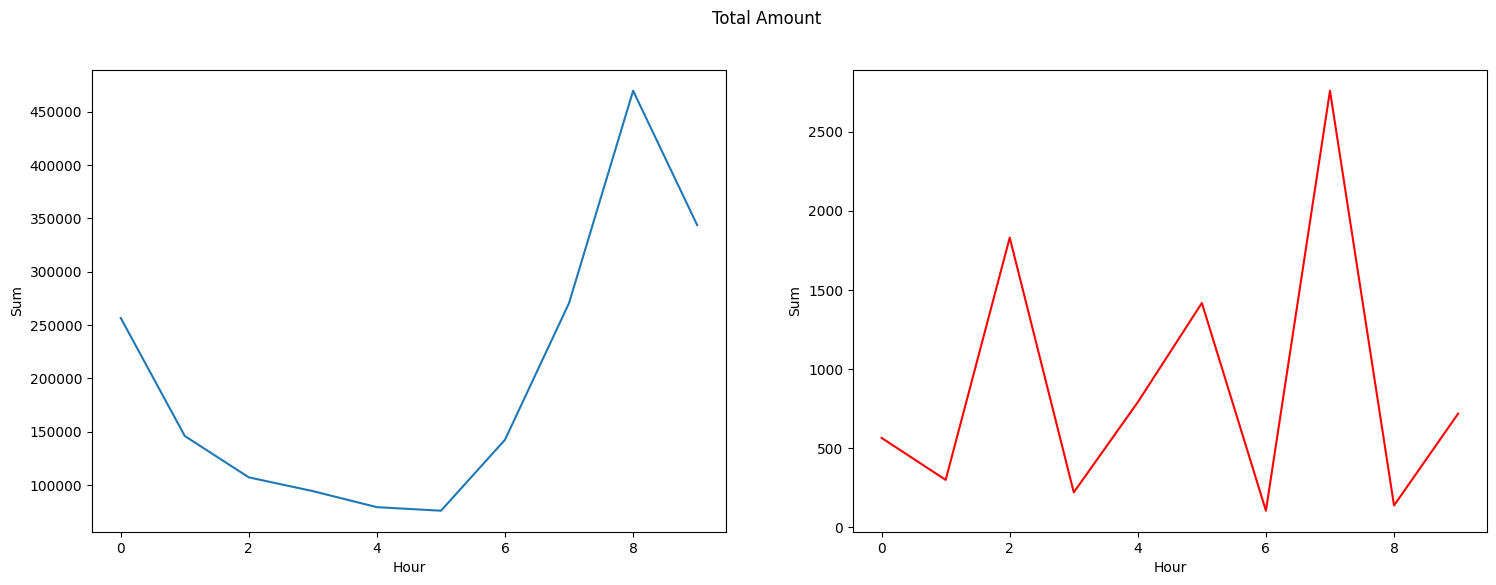

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Sum", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Sum", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Amount")
plt.show();

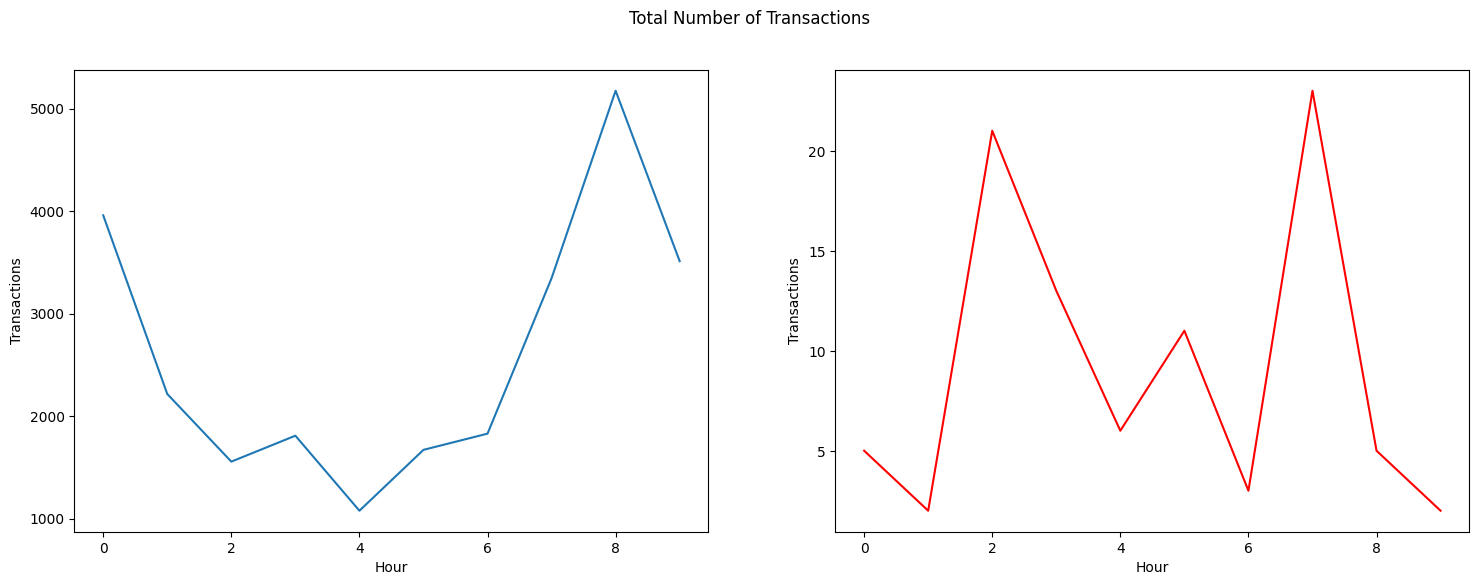

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Transactions", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Transactions", data=df.loc[df.Class==1], color="red")
plt.suptitle("Total Number of Transactions")
plt.show();

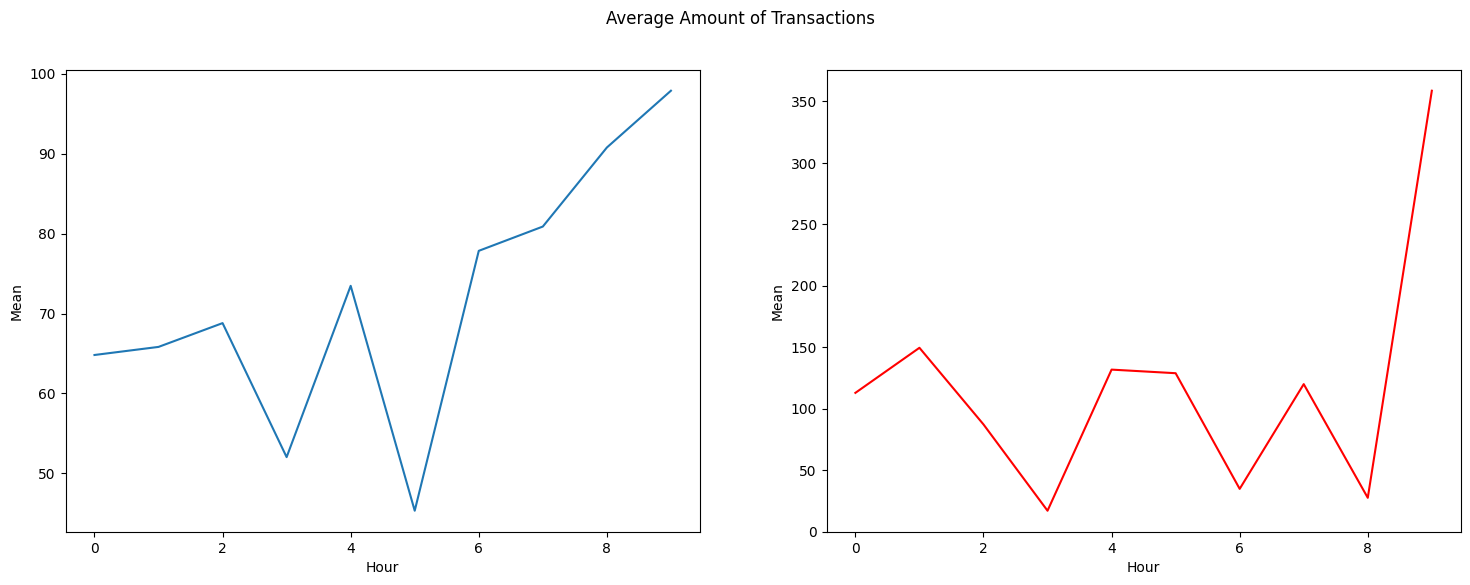

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Mean", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Mean", data=df.loc[df.Class==1], color="red")
plt.suptitle("Average Amount of Transactions")
plt.show();

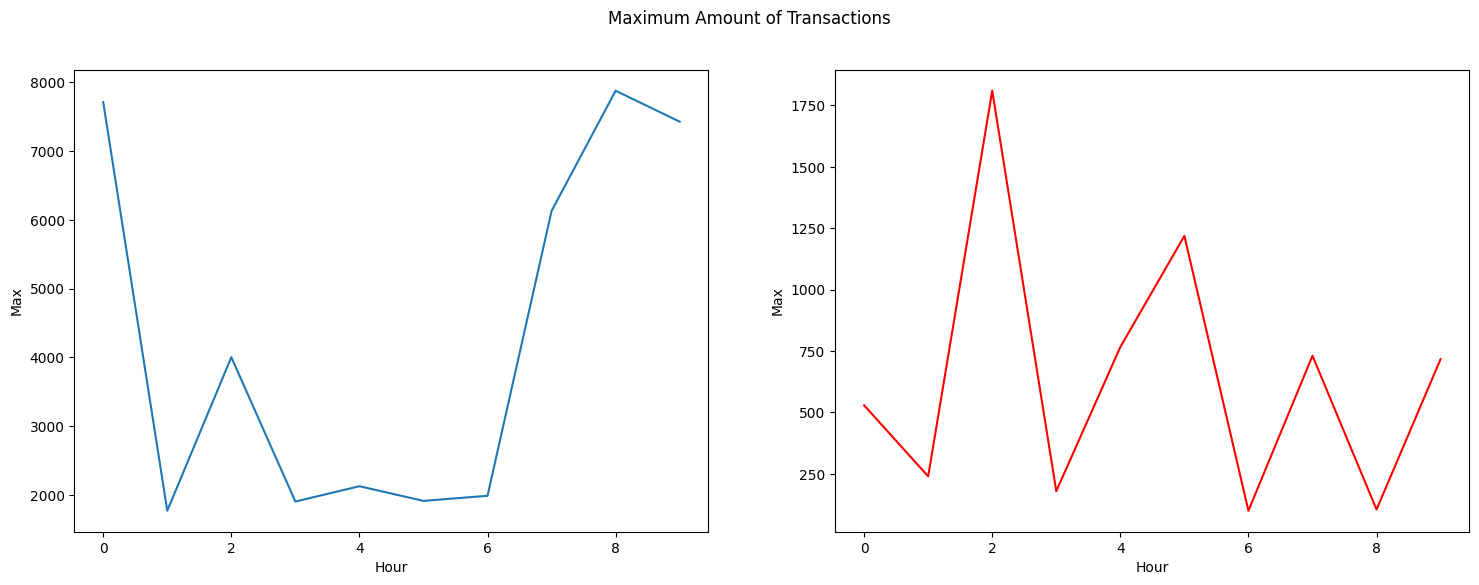

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Max", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Max", data=df.loc[df.Class==1], color="red")
plt.suptitle("Maximum Amount of Transactions")
plt.show();

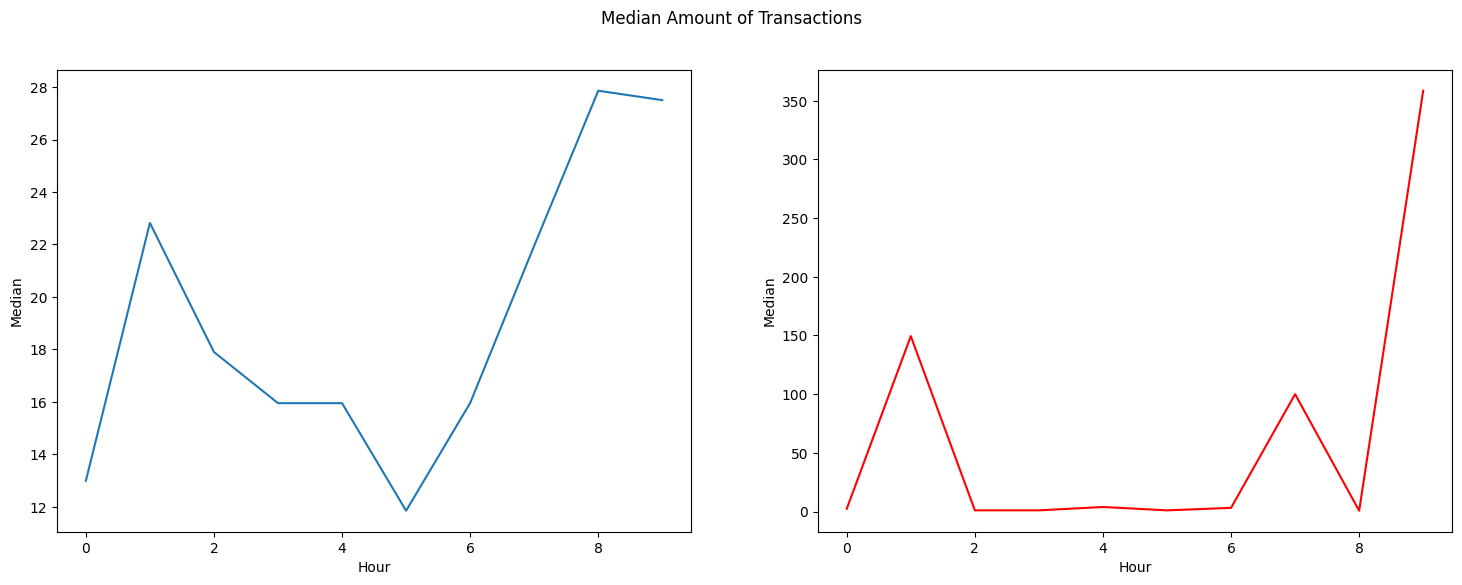

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Median", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Median", data=df.loc[df.Class==1], color="red")
plt.suptitle("Median Amount of Transactions")
plt.show();

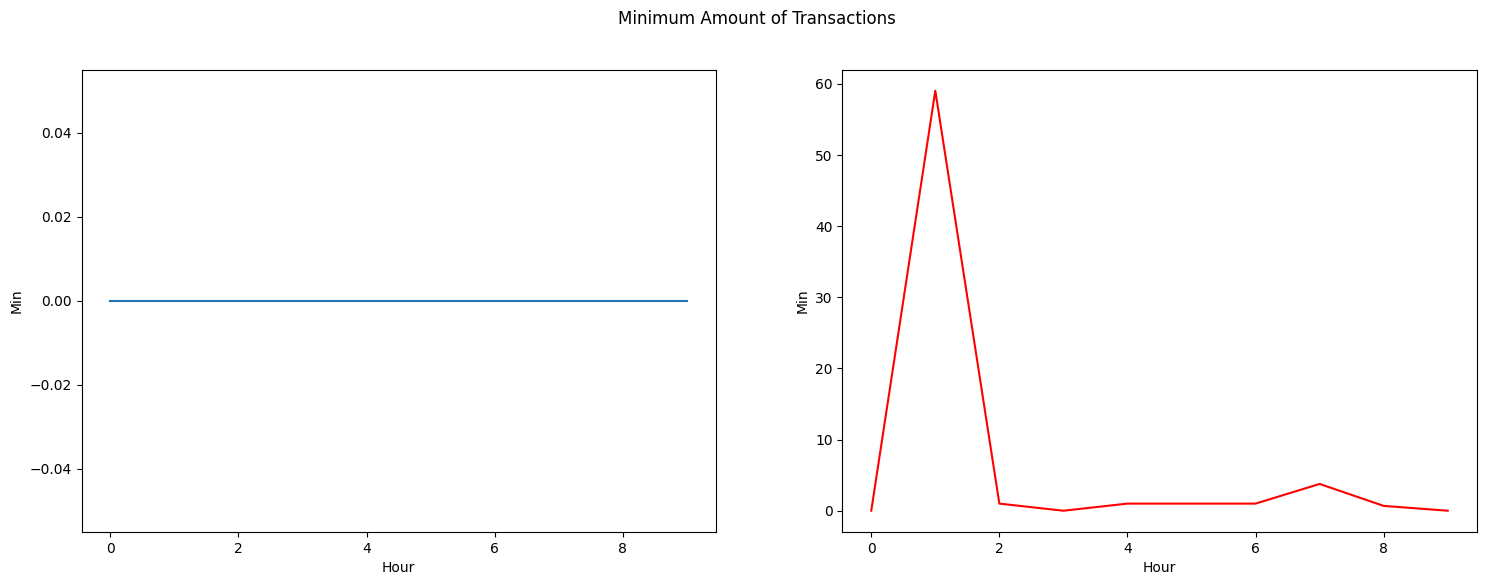

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))
s = sns.lineplot(ax = ax1, x="Hour", y="Min", data=df.loc[df.Class==0])
s = sns.lineplot(ax = ax2, x="Hour", y="Min", data=df.loc[df.Class==1], color="red")
plt.suptitle("Minimum Amount of Transactions")
plt.show();

## Transactions amount

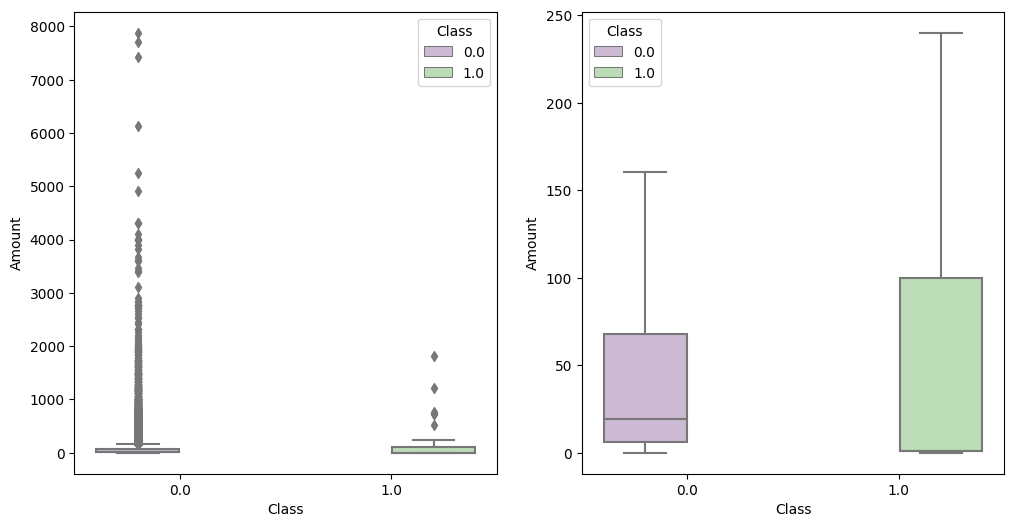

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
s = sns.boxplot(ax = ax1, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=True)
s = sns.boxplot(ax = ax2, x="Class", y="Amount", hue="Class",data=data_df, palette="PRGn",showfliers=False)
plt.show();

In [ ]:
tmp = data_df[['Amount','Class']].copy()
class_0 = tmp.loc[tmp['Class'] == 0]['Amount']
class_1 = tmp.loc[tmp['Class'] == 1]['Amount']
class_0.describe()

count    26140.000000
mean        75.910392
std        218.994361
min          0.000000
25%          6.250000
50%         19.015000
75%         67.952500
max       7879.420000
Name: Amount, dtype: float64

In [ ]:
class_1.describe()

count      91.000000
mean       97.097802
std       261.869231
min         0.000000
25%         1.000000
50%         1.000000
75%        99.990000
max      1809.680000
Name: Amount, dtype: float64

In [ ]:
fraud = data_df.loc[data_df['Class'] == 1]

trace = go.Scatter(
    x = fraud['Time'],y = fraud['Amount'],
    name="Amount",
     marker=dict(
                color='rgb(238,23,11)',
                line=dict(
                    color='red',
                    width=1),
                opacity=0.5,
            ),
    text= fraud['Amount'],
    mode = "markers"
)
data = [trace]
layout = dict(title = 'Amount of fraudulent transactions',
          xaxis = dict(title = 'Time [s]', showticklabels=True),
          yaxis = dict(title = 'Amount'),
          hovermode='closest'
         )
fig = dict(data=data, layout=layout)
iplot(fig, filename='fraud-amount')

## Features correlation

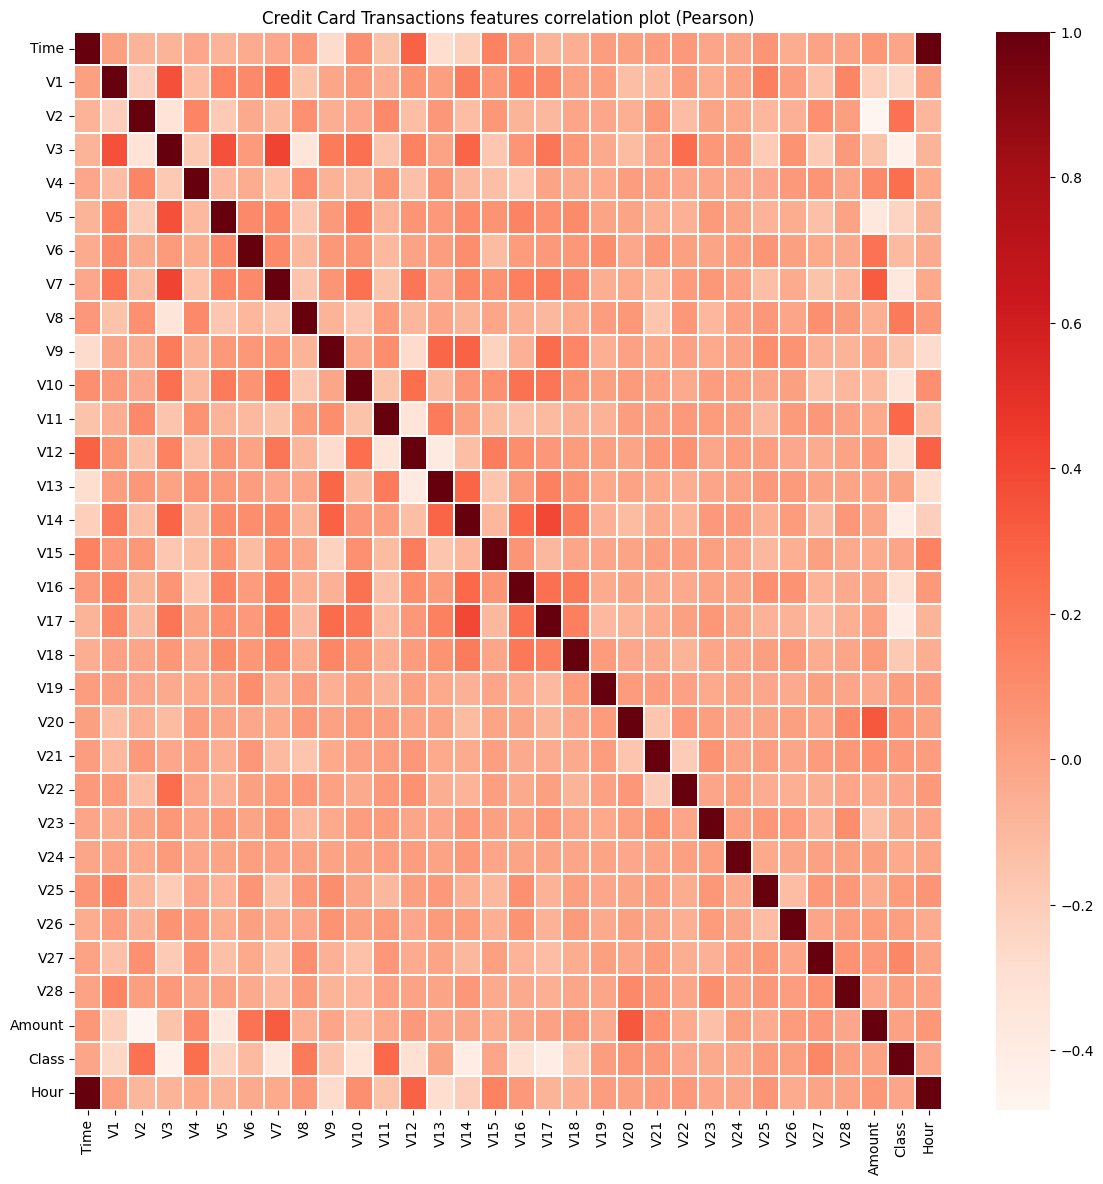

In [ ]:
plt.figure(figsize = (14,14))
plt.title('Credit Card Transactions features correlation plot (Pearson)')
corr = data_df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

As expected, there is no notable correlation between features **V1**-**V28**. There are certain correlations between some of these features and **Time** (inverse correlation with **V3**) and **Amount** (direct correlation with **V7** and **V20**, inverse correlation with **V1** and **V5**).


.

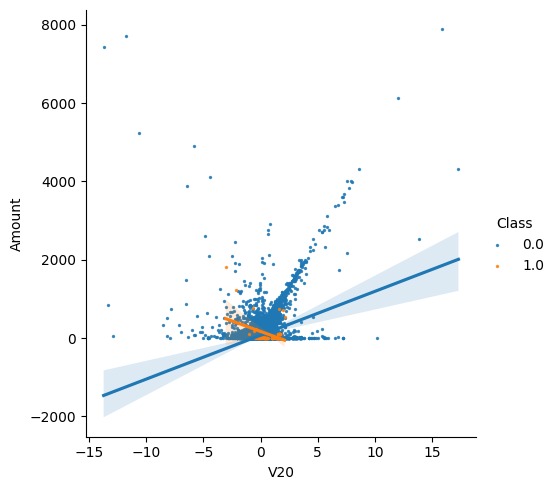

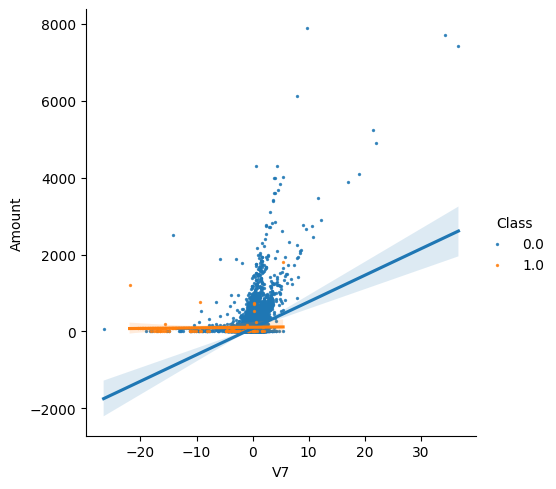

In [ ]:
s = sns.lmplot(x='V20', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V7', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

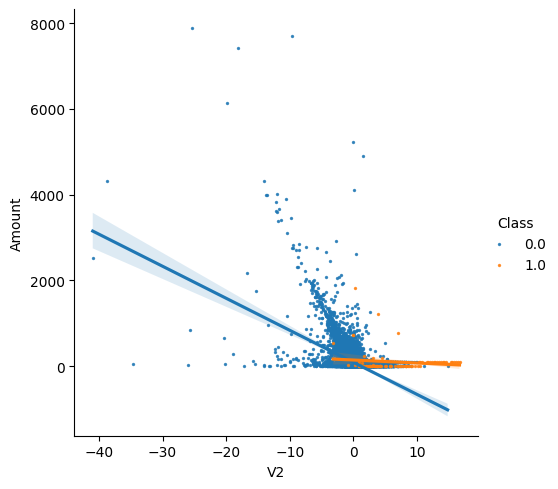

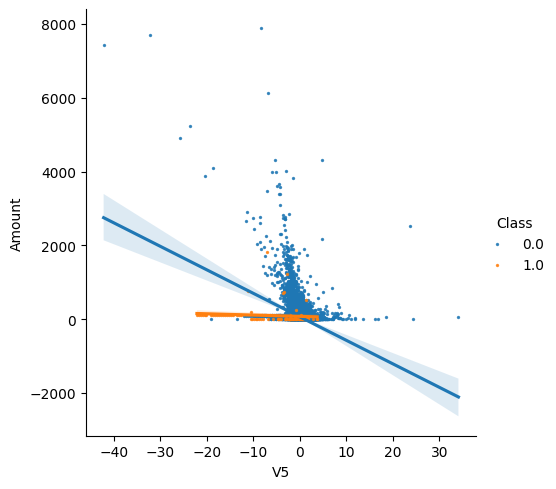

In [ ]:
s = sns.lmplot(x='V2', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
s = sns.lmplot(x='V5', y='Amount',data=data_df, hue='Class', fit_reg=True,scatter_kws={'s':2})
plt.show()

We can confirm that the two couples of features are inverse correlated (the regression lines for **Class = 0** have a negative slope while the regression lines for **Class = 1** have a very small negative slope).


## Features density plot

<ipython-input-25-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-25-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-25-49894014f345>:14: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.


<ipython-input-25-49894014f345>:15: UserWarning:



The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.5`, but please see the docs for the new parameter

<Figure size 640x480 with 0 Axes>

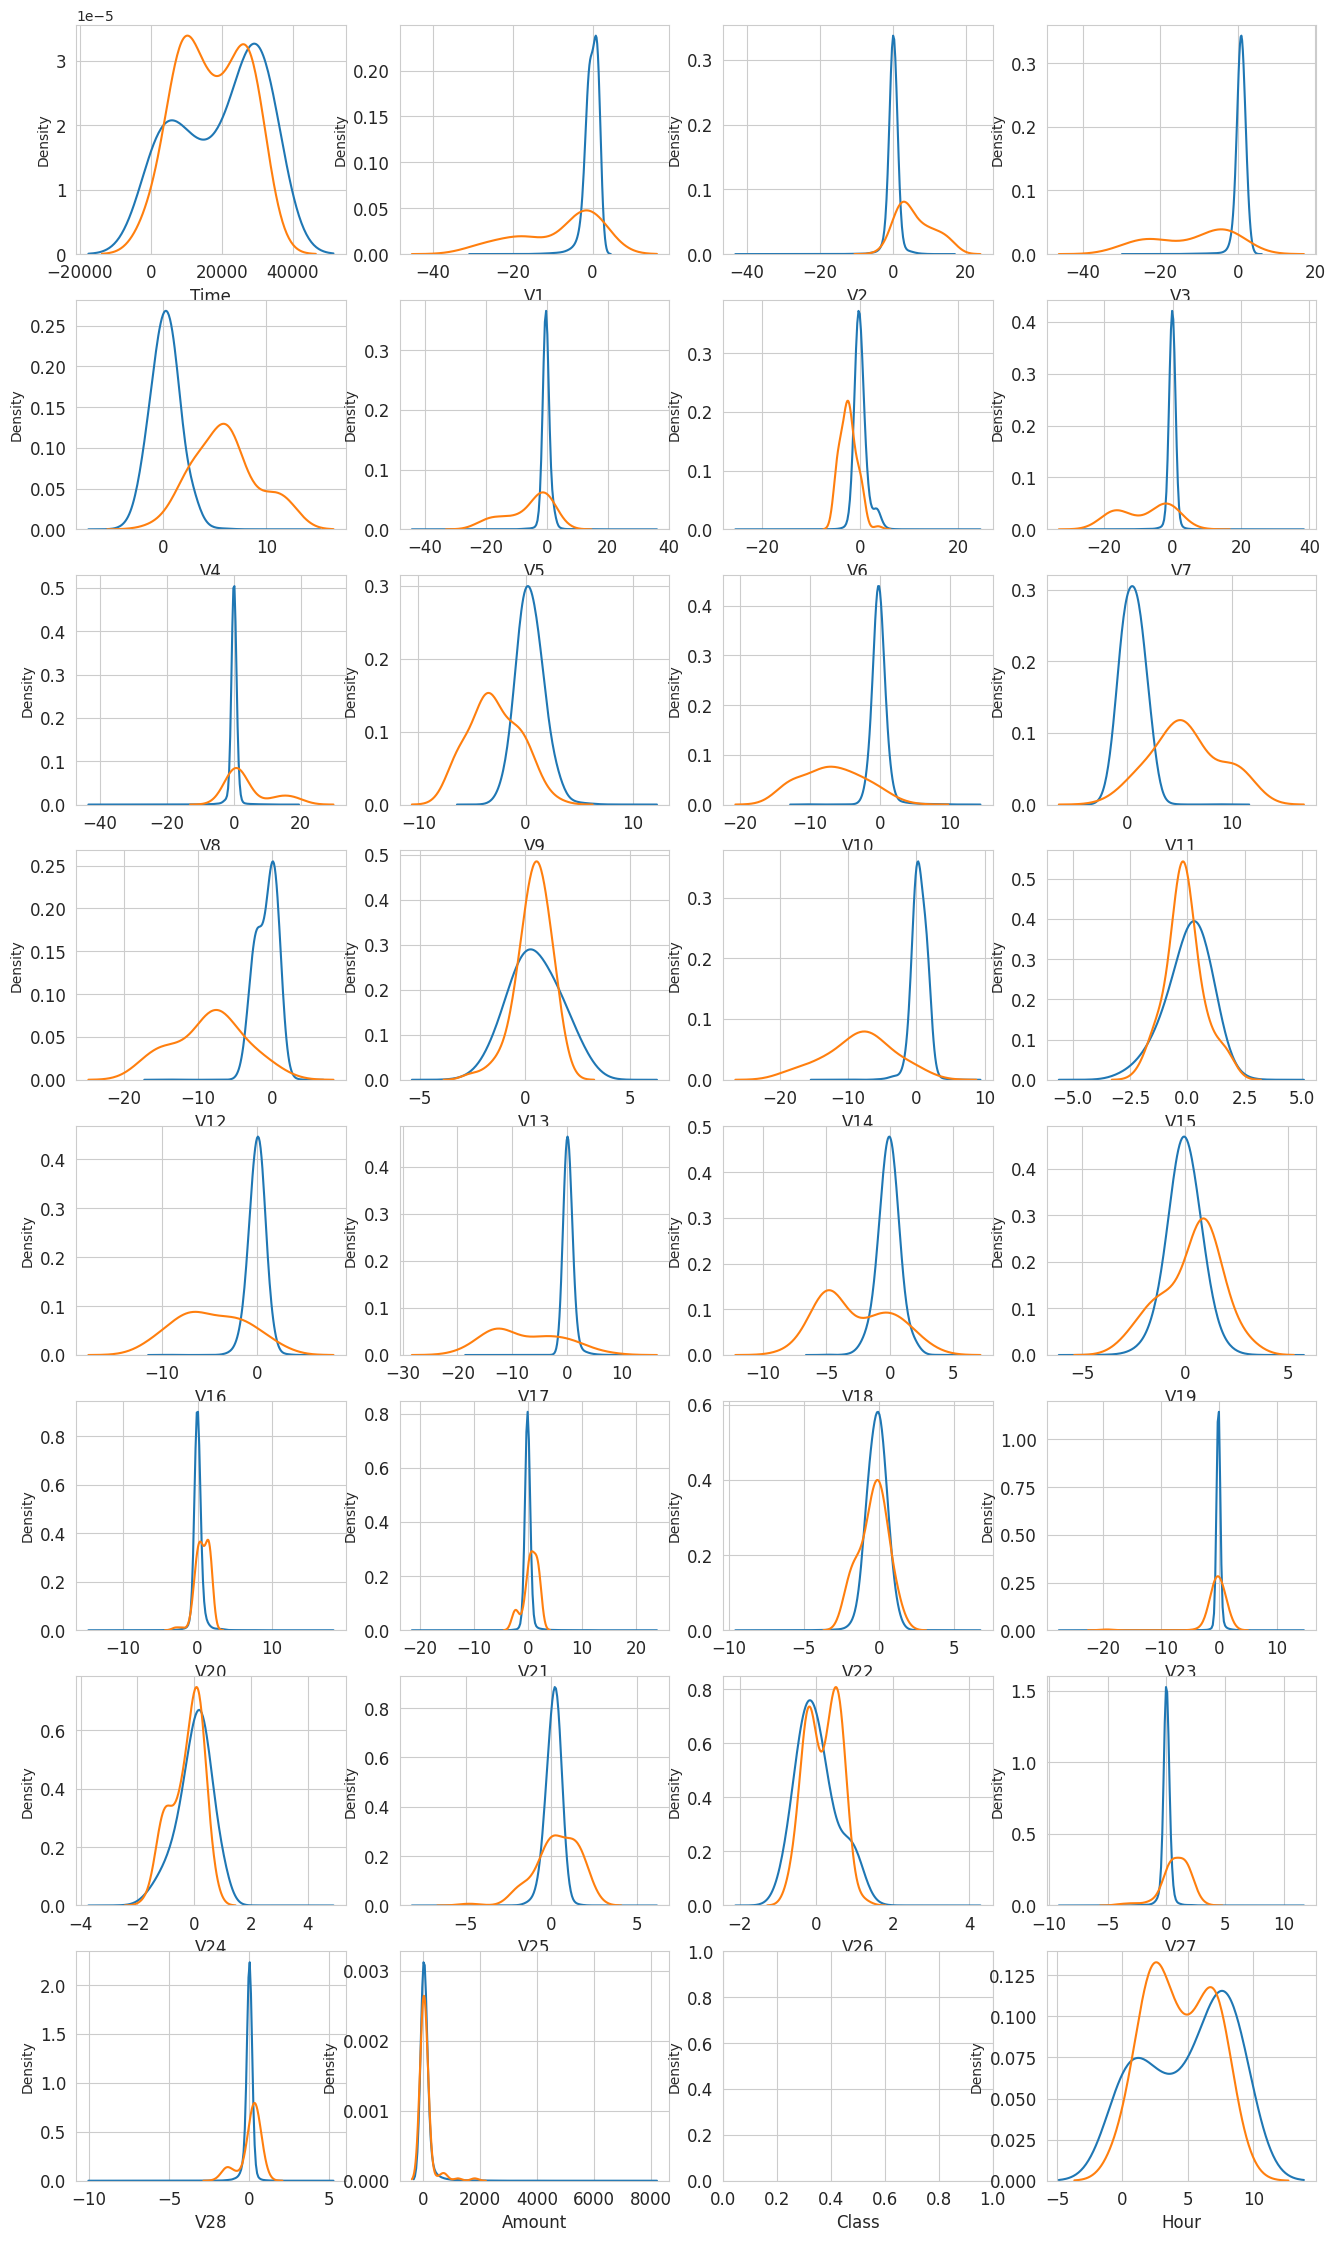

In [ ]:
var = data_df.columns.values

i = 0
t0 = data_df.loc[data_df['Class'] == 0]
t1 = data_df.loc[data_df['Class'] == 1]

sns.set_style('whitegrid')
plt.figure()
fig, ax = plt.subplots(8,4,figsize=(16,28))

for feature in var:
    i += 1
    plt.subplot(8,4,i)
    sns.kdeplot(t0[feature], bw=0.5,label="Class = 0")
    sns.kdeplot(t1[feature], bw=0.5,label="Class = 1")
    plt.xlabel(feature, fontsize=12)
    locs, labels = plt.xticks()
    plt.tick_params(axis='both', which='major', labelsize=12)
plt.show();

# Predictive models



### Define predictors and target values

Let's define the predictor features and the target features. Categorical features, if any, are also defined. In our case, there are no categorical feature.

In [ ]:
target = 'Class'
predictors = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',\
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',\
       'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28',\
       'Amount']

### Split data in train, test and validation set

Let's define train, validation and test sets.

In [ ]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_df, valid_df = train_test_split(train_df, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

## RandomForestClassifier


### Define model parameters


In [ ]:
clf = RandomForestClassifier(n_jobs=NO_JOBS,
                             random_state=RANDOM_STATE,
                             criterion=RFC_METRIC,
                             n_estimators=NUM_ESTIMATORS,
                             verbose=False)

Let's train the **RandonForestClassifier** using the **train_df** data and **fit** function.

In [ ]:
# Drop rows with missing values
train_df_dropna = train_df.dropna()

# Now, train your model using the data without missing values
clf.fit(train_df_dropna[predictors], train_df_dropna[target].values)

RandomForestClassifier(n_jobs=4, random_state=2018, verbose=False)

In [ ]:
train_df = train_df.dropna()
valid_df = valid_df.dropna()
preds = clf.predict(valid_df[predictors])



### Features importance

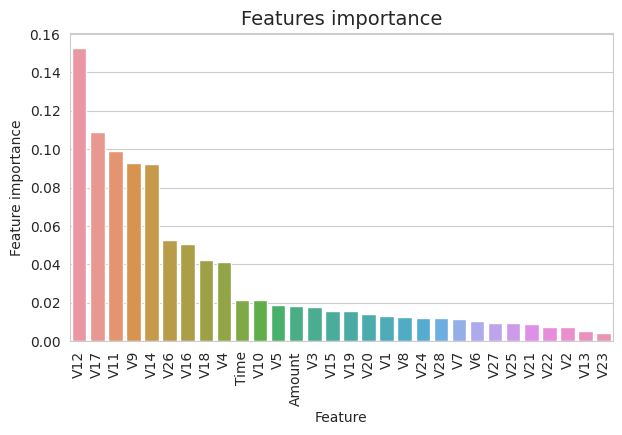

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()


The most important features are **V17**, **V12**, **V14**, **V10**, **V11**, **V16**.


### Confusion matrix



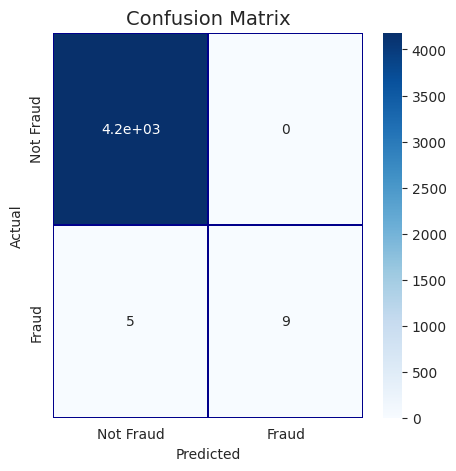

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8214285714285714

The **ROC-AUC** score obtained with **RandomForrestClassifier** is **1.0**.





## AdaBoostClassifier




### Prepare the model



In [ ]:
clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                         algorithm='SAMME.R',
                         learning_rate=0.8,
                             n_estimators=NUM_ESTIMATORS)

In [ ]:
# Drop rows with missing values
train_df_dropna = train_df.dropna()

# Now, train your model using the data without missing values
clf.fit(train_df_dropna[predictors], train_df_dropna[target].values)

AdaBoostClassifier(learning_rate=0.8, n_estimators=100, random_state=2018)

In [ ]:
preds = clf.predict(valid_df[predictors])

### Features importance



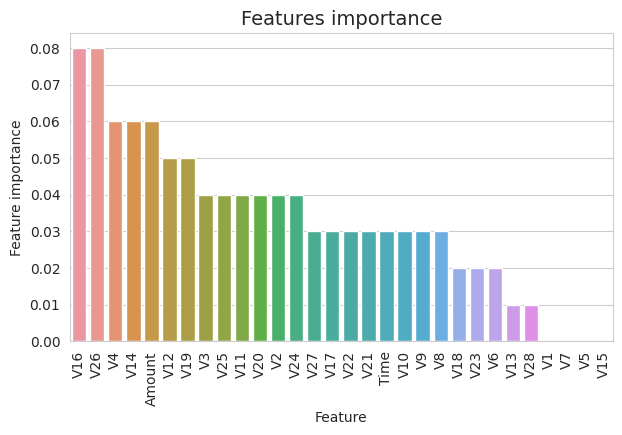

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion matrix

Let's visualize the confusion matrix.

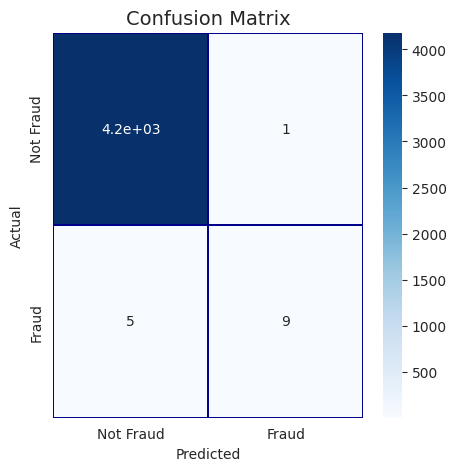

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()




### Area under curve

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8213090114094418

The ROC-AUC score obtained with AdaBoostClassifier is **0.83**.

## CatBoostClassifier




### Prepare the model



In [ ]:
clf = CatBoostClassifier(iterations=500,
                             learning_rate=0.02,
                             depth=12,
                             eval_metric='AUC',
                             random_seed = RANDOM_STATE,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = VERBOSE_EVAL,
                             od_wait=100)

In [ ]:
# Drop rows with missing values
train_df_dropna = train_df.dropna()

# Now, train your model using the data without missing values
clf.fit(train_df_dropna[predictors], train_df_dropna[target].values,verbose=True)

0:	total: 584ms	remaining: 4m 51s
50:	total: 28.1s	remaining: 4m 7s
100:	total: 54.9s	remaining: 3m 36s
150:	total: 1m 20s	remaining: 3m 6s
200:	total: 1m 45s	remaining: 2m 37s
250:	total: 2m 13s	remaining: 2m 12s
300:	total: 2m 38s	remaining: 1m 45s
350:	total: 3m 4s	remaining: 1m 18s
400:	total: 3m 30s	remaining: 52s
450:	total: 3m 57s	remaining: 25.8s
499:	total: 4m 32s	remaining: 0us


In [ ]:
preds = clf.predict(valid_df[predictors])

### Features importance



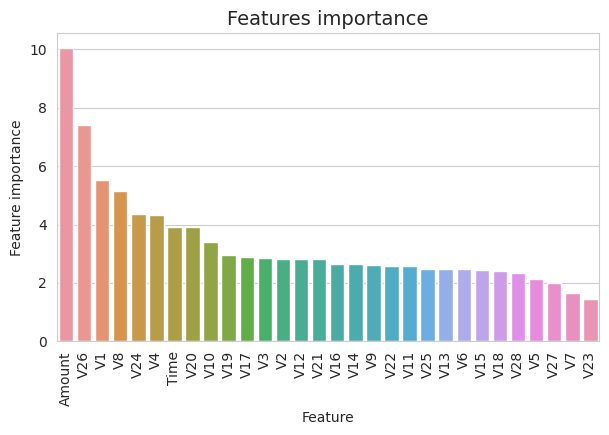

In [ ]:
tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

### Confusion matrix



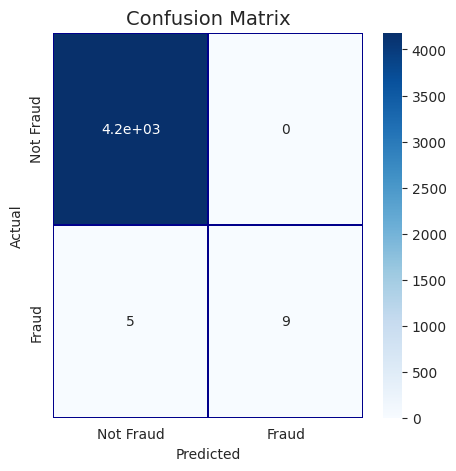

In [ ]:
cm = pd.crosstab(valid_df[target].values, preds, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(5,5))
sns.heatmap(cm,
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()




### Area under curve

In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8214285714285714

The ROC-AUC score obtained with CatBoostClassifier is **0.86**.

#Logistic Regression

In [ ]:
target_column = 'Class'

# Extract features and target variables
train_X = train_df.drop(target_column, axis=1)
train_y = train_df[target_column]

valid_X = valid_df.drop(target_column, axis=1)
valid_y = valid_df[target_column]

test_X = test_df.drop(target_column, axis=1)
test_y = test_df[target_column]

# Create and train the Logistic Regression model
model = LogisticRegression()
model.fit(train_X, train_y)
ypred = model.predict(test_X)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
roc_auc_score(valid_df[target].values, preds)

0.8214285714285714